# Application

In [1]:
# Importations de bibliothèques
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import linalg, optimize
from sklearn.datasets import make_sparse_spd_matrix
from sklearn.covariance import GraphicalLassoCV, ledoit_wolf
from sklearn import covariance, cluster
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns
import yfinance as yf
import statsmodels.api as sm
from statsmodels import regression
import cvxopt as opt
from cvxopt import blas, solvers
from datetime import timedelta


In [2]:
# List of tickers
tickers = [
    # Technology Sector
    "AAPL",  # Apple Inc.
    "MSFT",  # Microsoft Corporation
    "AMZN",  # Amazon.com Inc.
    "GOOGL", # Alphabet Inc. (Class A)
    "NVDA",  # NVIDIA Corporation
    "AMD",   # Advanced Micro Devices, Inc.

    # Healthcare Sector
    "MRK",   # Merck & Co., Inc.
    "ABT",   # Abbott Laboratories

    # Retail Sector
    "AMZN",  # Amazon.com Inc. (again for correlation with Alibaba)
    "BABA",  # Alibaba Group Holding Limited

    # Energy Sector
    "XOM",   # Exxon Mobil Corporation
    "CVX",   # Chevron Corporation

    # Financial Sector
    "JPM",   # JPMorgan Chase & Co.
    "BAC",   # Bank of America Corporation

    # Consumer Goods Sector
    "PG",    # Procter & Gamble Co.
    "KO",    # The Coca-Cola Company

    # Industrial Sector
    "BA",    # The Boeing Company
    "GE",    # General Electric Company

    # Transportation Sector
    "UPS",   # United Parcel Service, Inc.
    "FDX",   # FedEx Corporation

    # Entertainment Sector
    "DIS",   # The Walt Disney Company
    "NFLX",  # Netflix, Inc.
    
    # Additional Companies for Diversity
    "INTC",  # Intel Corporation
    "TSLA",  # Tesla, Inc.
    "IBM",   # International Business Machines Corporation
    "NKE",   # NIKE, Inc.
    "CSCO",  # Cisco Systems, Inc.
    "HD",    # The Home Depot, Inc.
    "CRM",   # Salesforce.com, Inc.
    "CMCSA", # Comcast Corporation
    "PEP",   # PepsiCo, Inc.
    "MCD",   # McDonald's Corporation
    "WMT",   # Walmart Inc.
    "TGT",   # Target Corporation
    "INTU",  # Intuit Inc.
    "VZ",    # Verizon Communications Inc.
    "TMUS",  # T-Mobile US, Inc.
    "WFC",   # Wells Fargo & Company
    "COST",  # Costco Wholesale Corporation
    "C",     # Citigroup Inc.
    "AMT",   # American Tower Corporation
    "LMT",   # Lockheed Martin Corporation
    "BAH",   # Booz Allen Hamilton Holding Corporation
    "LULU",  # Lululemon Athletica Inc.
]

#Affichage des 5 premiers
tickers[:5]

['AAPL', 'MSFT', 'AMZN', 'GOOGL', 'NVDA']

In [3]:
#Définition du début et fin de la collecte de données
start = '2010-01-01'
end = '2016-01-01'

#Collecte
data = yf.download(
    tickers,
    start,
    end
)
data.head()

[*********************100%%**********************]  43 of 43 completed


Price      Adj Close                                                      \
Ticker          AAPL        ABT   AMD        AMT    AMZN         BA BABA   
Date                                                                       
2010-01-04  6.461976  18.952168  9.70  33.703331  6.6950  43.777554  NaN   
2010-01-05  6.473150  18.799044  9.71  34.261692  6.7345  45.211346  NaN   
2010-01-06  6.370184  18.903439  9.57  34.440063  6.6125  46.582806  NaN   
2010-01-07  6.358408  19.060038  9.47  34.347000  6.5000  48.468555  NaN   
2010-01-08  6.400681  19.157480  9.43  34.416782  6.6760  48.001011  NaN   

Price                                 ...    Volume                     \
Ticker            BAC BAH          C  ...       PEP       PG       TGT   
Date                                  ...                                
2010-01-04  12.601925 NaN  26.409632  ...   6585900  9190800   4589100   
2010-01-05  13.011548 NaN  27.419399  ...   8886000  8649400   4760100   
2010-01-06  13.164151 NaN  28.273834  ...   9998000  9908400   7217400   
2010-01-07  13.597868 NaN  28.351507  ...  10792000  8972800  12531000   
2010-01-08  13.477393 NaN  27.885450  ...   8674700  8464600   6512800   

Price                                                                       
Ticker         TMUS TSLA       UPS        VZ       WFC       WMT       XOM  
Date                                                                        
2010-01-04  2656050  NaN   3897200  16176648  39335700  62259300  27809100  
2010-01-05  2088600  NaN   5966300  23722957  55416000  46945200  30174700  
2010-01-06  5595400  NaN   5770200  37506464  33237000  37551600  35044700  
2010-01-07  4430250  NaN   5747000  25508242  61649000  31988100  27192100  
2010-01-08  6763800  NaN  13779300  20658308  35508700  34089600  24891800  

[5 rows x 258 columns]

In [4]:
failed_tickers = data.columns.get_level_values(1)[data.isnull().any() | (data == 0).any()].unique().tolist()
tickers = [ticker for ticker in tickers if ticker not in failed_tickers]

In [5]:
data.drop(columns=failed_tickers, level=1, inplace=True)
data.head()

Price      Adj Close                                                      \
Ticker          AAPL        ABT        AMT    AMZN         BA        BAC   
Date                                                                       
2010-01-04  6.461976  18.952168  33.703331  6.6950  43.777554  12.601925   
2010-01-05  6.473150  18.799044  34.261692  6.7345  45.211346  13.011548   
2010-01-06  6.370184  18.903439  34.440063  6.6125  46.582806  13.164151   
2010-01-07  6.358408  19.060038  34.347000  6.5000  48.468555  13.597868   
2010-01-08  6.400681  19.157480  34.416782  6.6760  48.001011  13.477393   

Price                                                  ...     Volume  \
Ticker              C     CMCSA       COST        CRM  ...       NVDA   
Date                                                   ...              
2010-01-04  26.409632  6.349109  42.498642  18.680597  ...  800352640   
2010-01-05  27.419399  6.263058  42.369877  18.600702  ...  728697600   
2010-01-06  28.273834  6.218165  42.920700  18.568245  ...  649166680   
2010-01-07  28.351507  6.349109  42.713245  18.485853  ...  547789840   
2010-01-08  27.885450  6.330403  42.405636  18.513317  ...  478175960   

Price                                                                 \
Ticker           PEP       PG       TGT     TMUS       UPS        VZ   
Date                                                                   
2010-01-04   6585900  9190800   4589100  2656050   3897200  16176648   
2010-01-05   8886000  8649400   4760100  2088600   5966300  23722957   
2010-01-06   9998000  9908400   7217400  5595400   5770200  37506464   
2010-01-07  10792000  8972800  12531000  4430250   5747000  25508242   
2010-01-08   8674700  8464600   6512800  6763800  13779300  20658308   

Price                                     
Ticker           WFC       WMT       XOM  
Date                                      
2010-01-04  39335700  62259300  27809100  
2010-01-05  55416000  46945200  30174700  
2010-01-06  33237000  37551600  35044700  
2010-01-07  61649000  31988100  27192100  
2010-01-08  35508700  34089600  24891800  

[5 rows x 234 columns]

In [6]:
data.columns

MultiIndex([('Adj Close',  'AAPL'),
            ('Adj Close',   'ABT'),
            ('Adj Close',   'AMT'),
            ('Adj Close',  'AMZN'),
            ('Adj Close',    'BA'),
            ('Adj Close',   'BAC'),
            ('Adj Close',     'C'),
            ('Adj Close', 'CMCSA'),
            ('Adj Close',  'COST'),
            ('Adj Close',   'CRM'),
            ...
            (   'Volume',  'NVDA'),
            (   'Volume',   'PEP'),
            (   'Volume',    'PG'),
            (   'Volume',   'TGT'),
            (   'Volume',  'TMUS'),
            (   'Volume',   'UPS'),
            (   'Volume',    'VZ'),
            (   'Volume',   'WFC'),
            (   'Volume',   'WMT'),
            (   'Volume',   'XOM')],
           names=['Price', 'Ticker'], length=234)

In [7]:
s= set()
for column,_ in list(data.columns):
    s.add(column)
s

{'Adj Close', 'Close', 'High', 'Low', 'Open', 'Volume'}

In [8]:
closing_prices = data["Close"]
opening_prices = data["Open"]

variation = closing_prices-opening_prices
variation.head()

Ticker,AAPL,ABT,AMT,AMZN,BA,BAC,C,CMCSA,COST,CRM,...,NVDA,PEP,PG,TGT,TMUS,UPS,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,0.020714,0.129545,-0.030003,-0.1175,0.459999,0.450000,0.400002,0.110,0.279999,0.052500,...,-0.00050,0.050003,0.009998,0.079998,0.460000,0.000000,-0.112547,0.299999,0.163334,0.430000
2010-01-05,-0.007857,-0.215910,0.680000,0.0630,1.770000,0.460001,1.099998,-0.095,-0.029999,0.012501,...,0.00650,0.980000,0.009998,0.220001,0.080000,0.029999,-0.028137,0.799999,-0.133333,0.229996
2010-01-06,-0.121786,0.182325,0.169998,-0.1175,1.549999,0.180000,0.800003,-0.080,0.930000,-0.094999,...,0.00500,-0.630001,-0.090000,1.070000,-1.080000,-0.360001,-0.675282,0.080000,0.023335,0.570000
2010-01-07,-0.041786,0.220709,-0.139999,-0.1005,2.690002,0.250000,-0.400002,0.130,-0.370003,-0.119999,...,-0.00675,-0.379997,-0.060001,0.070000,0.060000,-0.549999,-0.347019,1.009998,-0.040001,-0.099998
2010-01-08,0.060000,0.139143,0.000000,0.1480,0.059998,-0.199999,-0.599998,-0.005,-0.190002,0.020000,...,0.00300,0.010002,0.079998,0.020000,-0.400001,0.399998,0.084410,-0.039999,-0.033333,-0.170006


In [9]:
alphas = np.logspace(-1.5, 1, num=10)
model = covariance.GraphicalLassoCV(alphas=alphas)

X = variation.copy()
X /= X.std(axis=0)
model.fit(X)

c:\Python312\Lib\site-packages\sklearn\covariance\_graph_lasso.py:191: ConvergenceWarning: graphical_lasso: did not converge after 100 iteration: dual gap: -1.089e-03
  warnings.warn(


GraphicalLassoCV(alphas=array([ 0.03162278,  0.05994843,  0.11364637,  0.21544347,  0.40842387,
        0.77426368,  1.46779927,  2.7825594 ,  5.27499706, 10.        ]))

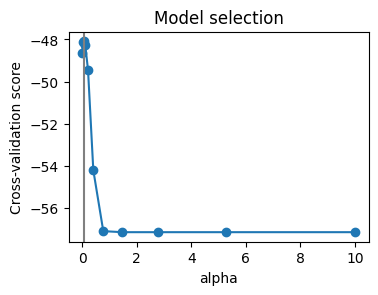

In [10]:
# plot the model selection metric
plt.figure(figsize=(4, 3))
plt.axes([0.2, 0.15, 0.75, 0.7])
plt.plot(model.cv_results_["alphas"], model.cv_results_["mean_test_score"], "o-")
plt.axvline(model.alpha_, color=".5")
plt.title("Model selection")
plt.ylabel("Cross-validation score")
plt.xlabel("alpha")

plt.show()

In [11]:
model.alpha_

0.05994842503189409

In [12]:
_, labels = cluster.affinity_propagation(model.covariance_, random_state=0)
n_labels = labels.max()
n_labels

9

In [13]:
labels

array([1, 1, 1, 0, 7, 3, 3, 1, 8, 0, 2, 9, 1, 7, 3, 0, 1, 9, 2, 7, 3, 5,
       7, 4, 7, 9, 2, 0, 1, 2, 5, 5, 8, 6, 7, 5, 3, 8, 9], dtype=int64)

In [14]:
clusters = {}

for i in range(len(labels)):
    cluster = labels[i]+1
    if cluster not in clusters:
        clusters[cluster]=[]
    clusters[cluster].append(tickers[i])

for cluster in clusters:
    print("Cluster "+str(cluster)+" : "+",".join(clusters[cluster]))

Cluster 2 : AAPL,MSFT,AMZN,AMZN,PG,UPS,MCD
Cluster 1 : GOOGL,CVX,GE,PEP
Cluster 8 : NVDA,KO,NFLX,NKE,HD,WFC
Cluster 4 : MRK,ABT,BA,INTC,C
Cluster 9 : XOM,VZ,AMT
Cluster 3 : JPM,DIS,CMCSA,WMT
Cluster 10 : BAC,FDX,CRM,LMT
Cluster 6 : IBM,TGT,INTU,COST
Cluster 5 : CSCO
Cluster 7 : TMUS


In [15]:
# Finding a low-dimension embedding for visualization: find the best position of
# the nodes (the stocks) on a 2D plane

from sklearn import manifold

node_position_model = manifold.LocallyLinearEmbedding(
    n_components=2, eigen_solver="dense", n_neighbors=6
)

embedding = node_position_model.fit_transform(X.T).T

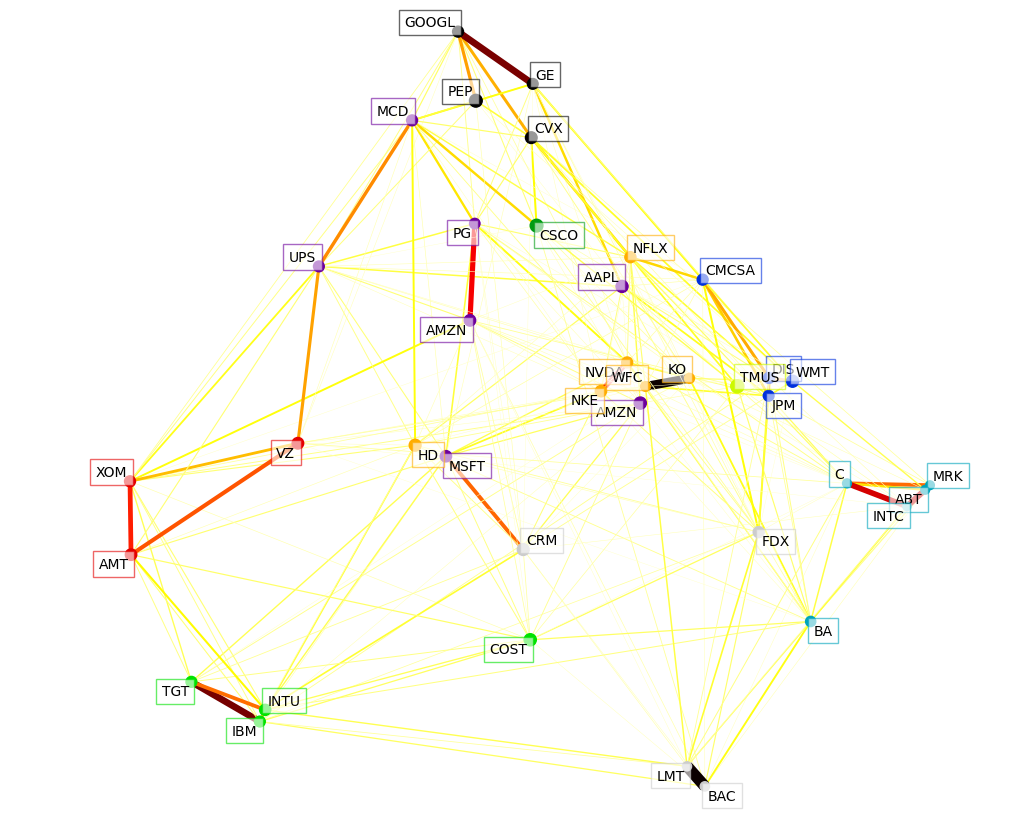

In [16]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

plt.figure(1, facecolor="w", figsize=(10, 8))
plt.clf()
ax = plt.axes([0.0, 0.0, 1.0, 1.0])
plt.axis("off")


partial_correlations = model.precision_.copy()
d = 1 / np.sqrt(np.diag(partial_correlations))
partial_correlations *= d
partial_correlations *= d[:, np.newaxis]
non_zero = np.abs(np.triu(partial_correlations, k=1)) > 0.02


plt.scatter(
    embedding[0], embedding[1], s=100 * d**2, c=labels, cmap=plt.cm.nipy_spectral
)

start_idx, end_idx = np.where(non_zero)
segments = [
    [embedding[:, start], embedding[:, stop]] for start, stop in zip(start_idx, end_idx)
]
values = np.abs(partial_correlations[non_zero])
lc = LineCollection(
    segments, zorder=0, cmap=plt.cm.hot_r, norm=plt.Normalize(0, 0.7 * values.max())
)
lc.set_array(values)
lc.set_linewidths(15 * values)
ax.add_collection(lc)

for index, (name, label, (x, y)) in enumerate(zip(tickers, labels, embedding.T)):
    dx = x - embedding[0]
    dx[index] = 1
    dy = y - embedding[1]
    dy[index] = 1
    this_dx = dx[np.argmin(np.abs(dy))]
    this_dy = dy[np.argmin(np.abs(dx))]
    if this_dx > 0:
        horizontalalignment = "left"
        x = x + 0.002
    else:
        horizontalalignment = "right"
        x = x - 0.002
    if this_dy > 0:
        verticalalignment = "bottom"
        y = y + 0.002
    else:
        verticalalignment = "top"
        y = y - 0.002
    plt.text(
        x,
        y,
        name,
        size=10,
        horizontalalignment=horizontalalignment,
        verticalalignment=verticalalignment,
        bbox=dict(
            facecolor="w",
            edgecolor=plt.cm.nipy_spectral(label / float(n_labels)),
            alpha=0.6,
        ),
    )

plt.xlim(
    embedding[0].min() - 0.15 * np.ptp(embedding[0]),
    embedding[0].max() + 0.10 * np.ptp(embedding[0]),
)
plt.ylim(
    embedding[1].min() - 0.03 * np.ptp(embedding[1]),
    embedding[1].max() + 0.03 * np.ptp(embedding[1]),
)

plt.show()

In [17]:

# Fonction qui prends les dates où on recalcule les poids et les noms des actifs sur lesquels on veut investir
# et qui retourne une liste de poids des investissements à faire à chaque date de 'dates'
def investing(dates,shares):
    #Initialiser
    weight_list=[]
    n=len(dates)-2
    for i in range(n): # pour chaque date i
        # Initialiser la liste des données historiques
        df_list = []
        for e in shares :
            df_list.append(yf.download(e, dates[i], dates[i+2])['Adj Close']) # Ajouter les dates sur an
        df = pd.concat(df_list, join = 'outer', axis = 1)
        df.columns = shares
        mu = expected_returns.mean_historical_return(df) # Calcule de la moyenne historique sur une année
        S = risk_models.sample_cov(df) 
        ef = EfficientFrontier(mu, S) # Calcule de la frontière efficace
        weights = ef.max_sharpe()  # calculer les poids qui maximisent le rapport de Sharpe
        clean_weights = ef.clean_weights() # arrondir les poids 
        weight_list.append(clean_weights)
    return weight_list


# Fonction qui retourne une liste des rapports de la valorisation d'un actif entre deux dates consecutives 
# et qui prends comme argument la liste des dates et les valorisations contenant les dates souhaitaient
def rapports(assets,dates):
    dates = pd.to_datetime(dates, format="%Y-%m-%d")
    ratios = []
    n = len(dates) -1
    six_months = timedelta(days=182)
    current_date = assets.index[0]
    for i in range(n):
        next_date = assets.index.asof(current_date + six_months)
        ratio = assets.loc[next_date] / assets.loc[current_date]
        ratios.append(ratio)
        current_date = next_date
    return ratios

# Fonctiom qui prends la liste de poids sur les dates générées par investing, les dates, le montant d'investissement 
# de départ, et les actifs sur lesquels on veut investir et qui retourne l'évolution du portefeuille sous forme de liste
def portfolio_evolution( weight_list , dates , montant_depart , shares):
    portefeuille_evolution = [montant_depart]
    n = len(dates) - 2
    rapport = { actif : rapports(yf.download(actif, dates[0], dates[-1])['Adj Close'],dates) for actif in shares} #dict des rapports obtenus par rapport
    for periode in range(n):
        weights = weight_list[periode]
        montant_actuel = portefeuille_evolution[-1]
        montant_suivant = sum( [ weights[actif]*montant_actuel*rapport[actif][periode] for actif in shares] ) 
        portefeuille_evolution.append(montant_suivant)
    return portefeuille_evolution

In [18]:

# Liste des dates où on va recalculer les poids 
# Chaque 6 mois de janvier 2010 à juin 2020
dates = ['2016-01-01','2016-06-01','2017-01-01','2017-06-01','2018-01-01','2018-06-01','2019-01-01','2019-06-01','2020-01-01','2020-06-01']
weight_list = investing(dates,tickers)
a= portfolio_evolution(weight_list,dates,10000,tickers)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

IndexError: index 0 is out of bounds for axis 0 with size 0

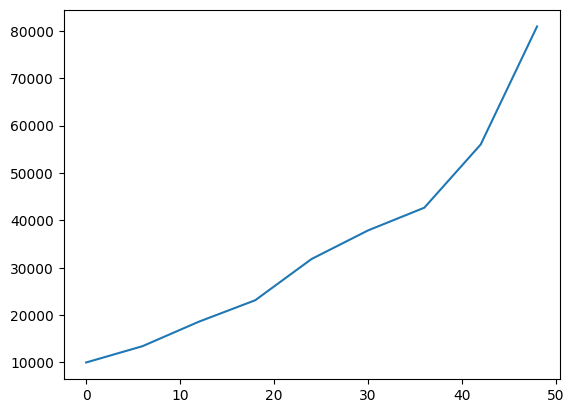

In [ ]:
plt.plot([6*i for i in range(len(a))],a)
plt.show()